In [6]:
#Import packages
import geopandas as gpd
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from shapely.geometry import LineString
import math
from shapely.affinity import translate
from shapely.geometry import Polygon

In [7]:
#Load shapefile
TestPoints = gpd.read_file('C:\Repo\Shoreline_Projections\Shapefiles\CapeEgmont_TEST_intersect2.shp')
# first mark change
#View shapefile table
TestPoints

,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,AOI,geometry
0,694,177,177,1,19/09/1955,11.059271,1.664816e+06,5.652014e+06,3.206634,CapeEgmont,POINT (1664816.274 5652014.454)
1,695,177,177,1,08/11/1970,9.226497,1.664818e+06,5.652014e+06,3.470649,CapeEgmont,POINT (1664818.097 5652014.267)
2,696,177,177,1,11/02/2017,6.706946,1.664821e+06,5.652014e+06,2.091626,CapeEgmont,POINT (1664820.603 5652014.011)
3,697,177,177,1,05/12/2020,5.195157,1.664822e+06,5.652014e+06,2.400562,CapeEgmont,POINT (1664822.107 5652013.857)
4,698,178,178,1,19/09/1955,10.972691,1.664816e+06,5.652004e+06,3.206634,CapeEgmont,POINT (1664815.895 5652003.931)
5,699,178,178,1,08/11/1970,9.455830,1.664817e+06,5.652004e+06,3.470649,CapeEgmont,POINT (1664817.410 5652003.850)
6,700,178,178,1,11/02/2017,7.331568,1.664820e+06,5.652004e+06,2.091626,CapeEgmont,POINT (1664819.531 5652003.737)
7,701,178,178,1,05/12/2020,6.193758,1.664821e+06,5.652004e+06,2.400562,CapeEgmont,POINT (1664820.667 5652003.677)


In [8]:
#Adding a new column with 1950 as the base date for all
TestPoints['BaseDate']= '1/1/1950'
TestPoints['BaseDate']=pd.to_datetime(TestPoints['BaseDate'])

#Adding new column and converts to datetime
TestPoints['Date']=pd.to_datetime(TestPoints['ShorelineI'])

# Finding the number of days between base date 1950 and the respective row date
TestPoints['ElapsedTime']=TestPoints.Date - TestPoints.BaseDate

#Adding another row with Date in 2100
TestPoints['to2100']='1/1/2100'

#Convert to datetime
TestPoints['to2100']=pd.to_datetime(TestPoints['to2100'])

#Finding number of days to 2100
TestPoints['Future'] = TestPoints.to2100 - TestPoints.Date

C:\Users\mdic039\AppData\Local\Temp\ipykernel_18904\1209900260.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  TestPoints['Date']=pd.to_datetime(TestPoints['ShorelineI'])


In [9]:
#View top of shaefile table
TestPoints.head(8)

,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,AOI,geometry,BaseDate,Date,ElapsedTime,to2100,Future
0,694,177,177,1,19/09/1955,11.059271,1.664816e+06,5.652014e+06,3.206634,CapeEgmont,POINT (1664816.274 5652014.454),1950-01-01,1955-09-19,2087 days,2100-01-01,52700 days
1,695,177,177,1,08/11/1970,9.226497,1.664818e+06,5.652014e+06,3.470649,CapeEgmont,POINT (1664818.097 5652014.267),1950-01-01,1970-11-08,7616 days,2100-01-01,47171 days
2,696,177,177,1,11/02/2017,6.706946,1.664821e+06,5.652014e+06,2.091626,CapeEgmont,POINT (1664820.603 5652014.011),1950-01-01,2017-02-11,24513 days,2100-01-01,30274 days
3,697,177,177,1,05/12/2020,5.195157,1.664822e+06,5.652014e+06,2.400562,CapeEgmont,POINT (1664822.107 5652013.857),1950-01-01,2020-12-05,25906 days,2100-01-01,28881 days
4,698,178,178,1,19/09/1955,10.972691,1.664816e+06,5.652004e+06,3.206634,CapeEgmont,POINT (1664815.895 5652003.931),1950-01-01,1955-09-19,2087 days,2100-01-01,52700 days
5,699,178,178,1,08/11/1970,9.455830,1.664817e+06,5.652004e+06,3.470649,CapeEgmont,POINT (1664817.410 5652003.850),1950-01-01,1970-11-08,7616 days,2100-01-01,47171 days
6,700,178,178,1,11/02/2017,7.331568,1.664820e+06,5.652004e+06,2.091626,CapeEgmont,POINT (1664819.531 5652003.737),1950-01-01,2017-02-11,24513 days,2100-01-01,30274 days
7,701,178,178,1,05/12/2020,6.193758,1.664821e+06,5.652004e+06,2.400562,CapeEgmont,POINT (1664820.667 5652003.677),1950-01-01,2020-12-05,25906 days,2100-01-01,28881 days


In [10]:
# New DataFrame with only latest X/Y coordinates for TestPoints
TestPoints_latest = TestPoints.sort_values('Date', ascending = False)
TestPoints_latest = TestPoints_latest.drop_duplicates('TransectID')

TestPoints_latest

,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,AOI,geometry,BaseDate,Date,ElapsedTime,to2100,Future
3,697,177,177,1,05/12/2020,5.195157,1.664822e+06,5.652014e+06,2.400562,CapeEgmont,POINT (1664822.107 5652013.857),1950-01-01,2020-12-05,25906 days,2100-01-01,28881 days
7,701,178,178,1,05/12/2020,6.193758,1.664821e+06,5.652004e+06,2.400562,CapeEgmont,POINT (1664820.667 5652003.677),1950-01-01,2020-12-05,25906 days,2100-01-01,28881 days


In [11]:
# To view what format each variable is in and converting ElapsedTime to seconds
TestPoints['ElapsedTimeSeconds'] = TestPoints['ElapsedTime'].dt.total_seconds().astype(float)

print(TestPoints.dtypes)

OBJECTID                        int64
TransectID                      int64
TransOrder                      int64
BaselineID                      int64
ShorelineI                     object
Distance                      float64
IntersectX                    float64
IntersectY                    float64
Uncertaint                    float64
AOI                            object
geometry                     geometry
BaseDate               datetime64[ns]
Date                   datetime64[ns]
ElapsedTime           timedelta64[ns]
to2100                 datetime64[ns]
Future                timedelta64[ns]
ElapsedTimeSeconds            float64
dtype: object


   TransectID     Slope  Intercept  PredictedDistance
0         177 -0.000425  11.238595         -12.028720
1         178 -0.000349  11.114625          -8.030394
Transect 177 - Distance difference: 12.265378788018685
Correlation coefficient: -0.00021234338817940315
Transect 178 - Distance difference: 10.09230807555314
Correlation coefficient: -0.00017472227546748968


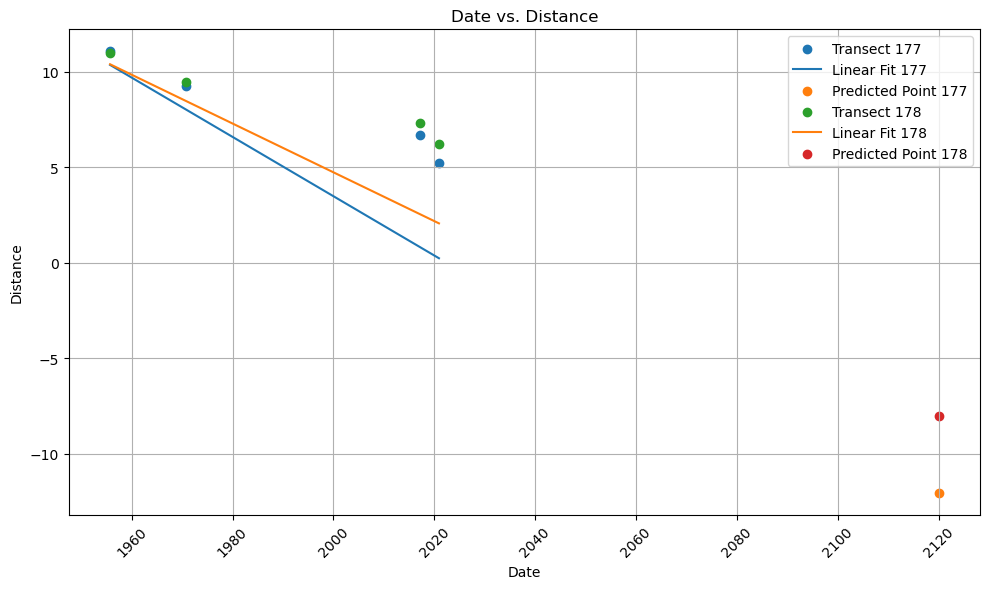

In [12]:
# Example data (replace this with your actual data)
dates = pd.to_datetime(TestPoints['Date'])  # Replace with your date values
distances = np.array(TestPoints['Distance'])  # Replace with your distance values

# Convert datetime to numerical values (days since a reference date)
reference_date = pd.to_datetime('1950-01-01')
numerical_dates = (dates - reference_date).dt.days

# Group data by Transect ID
grouped = TestPoints.groupby('TransectID')

# Perform linear regression for each group
results = []
for group_name, group_data in grouped:
    # Convert datetime to numerical values (days since a reference date)
    group_data['NumericalDate'] = (group_data['Date'] - reference_date).dt.days
    
    coefficients = np.polyfit(group_data['NumericalDate'], group_data['Distance'], 1)
    slope = 2 * coefficients[0]  # Multiply the slope by 2
    intercept = coefficients[1]

    # Calculate the predicted distance for the target date (2100-01-01)
    numerical_target_date = (pd.to_datetime('2100-01-01') - reference_date).days
    predicted_distance_target = slope * numerical_target_date + intercept

    results.append({
        'TransectID': group_name,
        'Slope': slope,
        'Intercept': intercept,
        'PredictedDistance': predicted_distance_target
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Calculate the absolute difference between the predicted distances and the old distances for each Transect ID
plt.figure(figsize=(10, 6))

for group_name, group_data in grouped:
    # Convert datetime to numerical values (days since a reference date)
    group_data['NumericalDate'] = (group_data['Date'] - reference_date).dt.days
    
    coefficients = np.polyfit(group_data['NumericalDate'], group_data['Distance'], 1)
    slope = 2 * coefficients[0]  # Multiply the slope by 2
    intercept = coefficients[1]
    
    # Calculate the predicted distance for the last old data point's date
    last_old_date = group_data['Date'].max()
    numerical_last_old_date = (last_old_date - reference_date).days
    predicted_distance_last_old = slope * numerical_last_old_date + intercept

    # Calculate the predicted distance for the target date
    numerical_target_date = (pd.to_datetime('2100-01-01') - reference_date).days
    predicted_distance_target = slope * numerical_target_date + intercept

    # Calculate the absolute difference between the predicted distances
    distance_difference = abs(predicted_distance_last_old - predicted_distance_target)

    plt.scatter(group_data['Date'], group_data['Distance'], label=f'Transect {group_name}')
    plt.plot(group_data['Date'], slope * group_data['NumericalDate'] + intercept, label=f'Linear Fit {group_name}')
    plt.scatter(numerical_target_date, predicted_distance_target, label=f'Predicted Point {group_name}')

    print(f"Transect {group_name} - Distance difference: {distance_difference}")
    print(f"Correlation coefficient: {coefficients[0]}")

plt.xlabel('Date')
plt.ylabel('Distance')
plt.title('Date vs. Distance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [13]:
print(group_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4 entries, 4 to 7
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   OBJECTID            4 non-null      int64          
 1   TransectID          4 non-null      int64          
 2   TransOrder          4 non-null      int64          
 3   BaselineID          4 non-null      int64          
 4   ShorelineI          4 non-null      object         
 5   Distance            4 non-null      float64        
 6   IntersectX          4 non-null      float64        
 7   IntersectY          4 non-null      float64        
 8   Uncertaint          4 non-null      float64        
 9   AOI                 4 non-null      object         
 10  geometry            4 non-null      geometry       
 11  BaseDate            4 non-null      datetime64[ns] 
 12  Date                4 non-null      datetime64[ns] 
 13  ElapsedTime         4 non-null      

In [14]:
import geopandas as gpd
from shapely.geometry import LineString

# Replace 'path_to_shapefile' with the actual path to your shapefile
shapefile_path = 'CapeEgmont_TEST_Line2.shp'
TransectLine = gpd.read_file(shapefile_path)

#Line shapefiles have azimuth 
TransectLine

DriverError: CapeEgmont_TEST_Line2.shp: No such file or directory

In [ ]:
import math

def calculate_new_coordinates(old_x, old_y, bearing, distance):
    bearing_radians = math.radians(bearing)
    new_x = old_x + (distance * math.sin(bearing_radians))
    new_y = old_y + (distance * math.cos(bearing_radians))
    return new_x, new_y

# Calculate New X/Y coordinates for each Transect
new_TransectLine = TransectLine[['TransectID', 'Azimuth']]
new_TransectLine = new_TransectLine.merge(TestPoints_latest[['TransectID', 'IntersectX', 'IntersectY']], on = 'TransectID')

new_TransectLine[['NewX', 'NewY']] = new_TransectLine.apply(lambda row: calculate_new_coordinates(row['IntersectX'],
                                                                                                 row['IntersectY'],
                                                                                                 row['Azimuth'],
                                                                                                 distance_difference),
                                                           axis = 1,
                                                           result_type = 'expand')

new_TransectLine = new_TransectLine.sort_values('TransectID', ascending = True)
new_TransectLine

,TransectID,Azimuth,IntersectX,IntersectY,NewX,NewY
0,1,29.08,1.715834e+06,5.609467e+06,1.715837e+06,5.609474e+06
1,2,28.99,1.715842e+06,5.609461e+06,1.715845e+06,5.609468e+06
2,3,29.15,1.715846e+06,5.609451e+06,1.715850e+06,5.609458e+06
3,4,30.39,1.715855e+06,5.609447e+06,1.715859e+06,5.609454e+06
4,5,31.55,1.715864e+06,5.609443e+06,1.715868e+06,5.609449e+06
...,...,...,...,...,...,...
803,813,53.52,1.715230e+06,5.610072e+06,1.715236e+06,5.610077e+06
804,814,53.31,1.715235e+06,5.610064e+06,1.715241e+06,5.610068e+06
805,815,53.06,1.715242e+06,5.610056e+06,1.715248e+06,5.610061e+06
806,816,52.77,1.715250e+06,5.610050e+06,1.715256e+06,5.610055e+06


<AxesSubplot:>

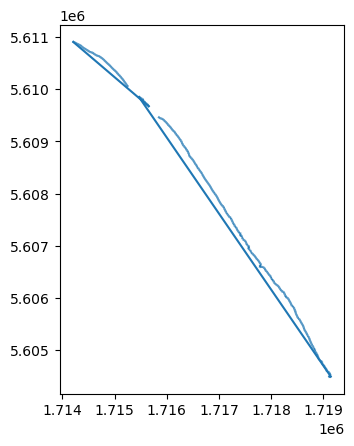

In [ ]:
# Convert Dataframe to geodataframe
new_TransectLine = gpd.GeoDataFrame(new_TransectLine, geometry = gpd.points_from_xy(new_TransectLine.NewX, 
                                                                       new_TransectLine.NewY),
                                    crs = 'EPSG:2193').rename(columns = {'geometry': 'from_point'})
# Get from and to points
new_TransectLine['to_point'] = new_TransectLine.from_point.shift(-1)
new_TransectLine.loc[new_TransectLine["to_point"].isna(), "to_point"] = new_TransectLine["from_point"]

# Get Line geometry between points
new_TransectLine['geometry'] = new_TransectLine.apply(lambda row: LineString([row['from_point'], row['to_point']]),
                                                 axis = 1)
new_TransectLine.plot()

In [ ]:
#Add code to nake line into polygon extending 500m out to the left
def extend(line):
  return line.union(translate(line, xoff=-500)).convex_hull

Shoreline_polygon = new_TransectLine.geometry.apply(extend)

Shoreline_polygon.plot()

In [ ]:
# Assuming Shoreline_polygon is a GeoSeries containing your geometries
# If it's a GeoDataFrame, you can use gdf = Shoreline_polygon instead
Shoreline_polygon = gpd.GeoSeries(Shoreline_polygon)

# Filter out LINESTRING geometries from the GeoSeries
filtered_geometries = Shoreline_polygon[Shoreline_polygon.type == 'Polygon']

# Define the path where you want to save the shapefile
output_shapefile = "C:/Users/lalit/GitHub/Shoreline_Projections/Projected_Shoreline_Polygons/AOIname_linear.shp"

# Create a GeoDataFrame from the filtered POLYGON geometries
gdf = gpd.GeoDataFrame(geometry=filtered_geometries)

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_shapefile)

# Verify that the shapefile has been created successfully
print(f"Shapefile saved to {output_shapefile}")

Shapefile exported successfully!
